# Stock price prediction by using ML algos (stock: VOO)

### Overview
1. Data selection & features manipulation
2. Basic model building
3. Model training algorithm
4. Backtesting
5. Model tuning
6. Results & implementation

#future work\
Feature engineering: overnight market / interest rate / CPI / sector & industry performance\
Model tuning: keeping finding good hyperparameters to get a better performance

### 1. Data selection & features manipulation

In [171]:
import vectorbt as vbt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [172]:
# Get stock price
start = '1990-01-01'
# end = datetime.now()
end = '2023-09-08'
stock_df = vbt.YFData.download('VOO', start=start, end=end).get()

In [173]:
# Create target variable (tmr's close v.s. today's close)
stock_df['tmr_close'] = stock_df['Close'].shift(-1)
stock_df['target'] = (stock_df['tmr_close'] > stock_df['Close']).astype(int)

# Add MA features
MA_list = [5,15,30,45,60,90,150]
new_predictors = []
for i in MA_list:
    ratio_column = f'ratio_{i}'
    stock_df[ratio_column] = stock_df.Close / stock_df.Close.rolling(i).mean()
    trend_column = f'trend_{i}'
    stock_df[trend_column] = stock_df.target.shift(1).rolling(i).sum()
    new_predictors += [ratio_column, trend_column]

# Add RSI features
rsi_list = [14, 30, 60, 90, 150]
for window in rsi_list:
    rsi_column = f'rsi_{window}'
    rsi = vbt.RSI.run(stock_df.Close, window=window)
    stock_df[rsi_column] = rsi.rsi
    new_predictors += [rsi_column]

In [174]:
# Add deterministic features (optional)

# stock_df['time_series'] = np.arange(1, len(stock_df)+1)
# stock_df['time_series_squared'] = np.arange(1, len(stock_df)+1)**2

In [175]:
# Add CPI feature (optional)

# CPI_raw = pd.read_csv('./SeriesReport.csv', index_col='CPI for All Urban Consumers (CPI-U)')
# CPI_raw = CPI_raw[CPI_raw.index.str.isnumeric().fillna(False)]
# CPI = pd.DataFrame(np.empty(len(CPI_raw)*12), columns=['CPI'])
# new_index = []
# for i in range(len(CPI_raw)):
#     for j in range(12):
#         CPI.iloc[(i*12)+j,0] = CPI_raw.iloc[i,j]
#         new_index.append(str(i+int(CPI_raw.index[0]))+'-'+str(j+1).zfill(2))
#         # new_index.append(datetime(i+int(CPI_raw.index[0]),j+1,1))
# new_index = pd.Series(new_index,name='year-month')
# CPI = CPI.set_index(new_index)

In [176]:
# Add fed rate feature (optional)

# fed_rates = pd.read_csv('./FEDFUNDS.csv', index_col='DATE')
# fed_rates = fed_rates.set_index(fed_rates.index.str[:-3])


#Join (optional)

# new_features = CPI.merge(fed_rates, left_on='year-month', right_on='DATE',how='left').set_index(CPI.index)
# new_features.index.name = 'year-month'


In [177]:
# Merge new features to main table (optional)

# stock_df['year-month'] = stock_df.index.year.astype(str) + '-' + stock_df.index.month.astype(str).str.zfill(2)
# stock_df = pd.merge(stock_df, new_features, on='year-month', how='left').set_index(stock_df.index)

# del stock_df['year-month']

# stock_df.CPI = stock_df.CPI.astype(float)


In [178]:
# Normalize data (optional)

# stock_df_raw = stock_df.copy()

# from sklearn.preprocessing import StandardScaler
# scale = StandardScaler()
# stock_df[stock_df.columns[stock_df.columns != 'target']] = scale.fit_transform(stock_df[stock_df.columns[stock_df.columns != 'target']])
# stock_df = pd.DataFrame(stock_df, columns = stock_df_raw.columns, index=stock_df_raw.index)


In [179]:
stock_df_last_date = stock_df.iloc[-1:].copy()
stock_df.dropna(inplace=True)

unwanted_variables = ['Dividends', 'Stock Splits', 'target', 'tmr_close']
predictors = [predictor for predictor in stock_df.columns if predictor not in unwanted_variables]

In [180]:
stock_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,tmr_close,target,...,trend_60,ratio_90,trend_90,ratio_150,trend_150,rsi_14,rsi_30,rsi_60,rsi_90,rsi_150
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-13 04:00:00+00:00,96.039120,96.086810,95.212572,95.594055,185100,0.0,0.0,0.0,95.609932,1,...,34.0,1.020028,55.0,1.061410,88.0,55.357267,51.649532,52.591170,58.172552,60.755073
2011-04-14 04:00:00+00:00,95.037702,95.768882,94.703903,95.609932,78450,0.0,0.0,0.0,95.943741,1,...,35.0,1.019323,56.0,1.060340,88.0,52.380989,47.074816,54.036968,58.335556,60.575035
2011-04-15 04:00:00+00:00,95.768892,96.198065,95.546360,95.943741,79700,0.0,0.0,0.0,94.894669,0,...,36.0,1.021968,56.0,1.062847,88.0,58.846008,50.143642,54.651607,58.623623,60.220629
2011-04-18 04:00:00+00:00,94.815194,95.053619,94.131697,94.894669,151650,0.0,0.0,0.0,95.482773,1,...,35.0,1.010061,55.0,1.050126,88.0,39.721141,49.519133,52.776271,56.901446,59.395770
2011-04-19 04:00:00+00:00,95.069499,95.482773,94.831068,95.482773,78900,0.0,0.0,0.0,96.770309,1,...,35.0,1.015554,55.0,1.055500,88.0,38.868894,48.612175,52.800755,57.149689,59.601611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 04:00:00+00:00,413.029999,415.029999,412.399994,414.359985,3004500,0.0,0.0,0.0,413.829987,0,...,36.0,1.041421,51.0,1.073102,84.0,55.654512,47.326450,58.728373,58.689150,56.482011
2023-08-31 04:00:00+00:00,414.980011,416.119995,413.660004,413.829987,4751100,0.0,0.0,0.0,414.709991,1,...,35.0,1.039038,50.0,1.070897,83.0,55.448697,48.802266,58.246690,58.448097,55.953798
2023-09-01 04:00:00+00:00,416.459991,416.880005,413.209991,414.709991,3587100,0.0,0.0,0.0,412.899994,0,...,36.0,1.039998,51.0,1.072345,83.0,53.820585,49.397579,59.083533,60.288942,55.933797


### 2. Basic model building

In [181]:
from sklearn.model_selection import cross_val_score
baseline = {}
models = []

train_x, train_y= stock_df[predictors], stock_df.target
cv_num=5

In [182]:
# rf
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
models.append(rf)
cv = cross_val_score(rf, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['rf'] = cv.mean()

[0.50961538 0.48397436 0.46634615 0.49519231 0.4599359 ]
0.4830128205128205


In [183]:
# gnb
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
models.append(gnb)
cv = cross_val_score(gnb, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['gnb'] = cv.mean()

[0.54166667 0.54326923 0.54326923 0.55288462 0.46153846]
0.528525641025641


In [184]:
# lr
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
models.append(lr)
cv = cross_val_score(lr, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['lr'] = cv.mean()

[0.54166667 0.54166667 0.54166667 0.5400641  0.5400641 ]
0.5410256410256411


In [185]:
# dt
from sklearn import tree
dt = tree.DecisionTreeClassifier(random_state=1)
models.append(dt)
cv = cross_val_score(dt, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['dt'] = cv.mean()

[0.47916667 0.5224359  0.46955128 0.46153846 0.46794872]
0.4801282051282052


In [186]:
# knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
models.append(knn)
cv = cross_val_score(knn, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['knn'] = cv.mean()

[0.5        0.52724359 0.50961538 0.52724359 0.49679487]
0.5121794871794872


In [187]:
# svc (optional due to too long running time)

# from sklearn.svm import SVC
# svc = SVC(probability=True, C=0.1, kernel='linear')
# cv = cross_val_score(svc, train_x, train_y, cv=cv_num)
# print(cv)
# print(cv.mean())


In [188]:
# xgb
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1)
models.append(xgb)
cv = cross_val_score(xgb, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['xgb'] = cv.mean()

[0.49358974 0.4775641  0.48717949 0.49839744 0.46634615]
0.48461538461538467


In [189]:
# voting_clf_soft
from sklearn.ensemble import VotingClassifier
voting_clf_soft = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('xgb',xgb)], voting = 'soft')
models.append(voting_clf_soft)
cv = cross_val_score(voting_clf_soft, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['voting_clf_soft'] = cv.mean()

[0.50961538 0.48717949 0.50320513 0.50641026 0.46314103]
0.4939102564102564


In [190]:
# voting_clf_hard
from sklearn.ensemble import VotingClassifier
voting_clf_hard = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('xgb',xgb)], voting = 'hard')
models.append(voting_clf_hard)
cv = cross_val_score(voting_clf_hard, train_x, train_y, cv=cv_num)
print(cv)
print(cv.mean())
baseline['voting_clf_hard'] = cv.mean()

[0.52083333 0.52564103 0.53205128 0.54647436 0.46314103]
0.5176282051282051


In [191]:
baseline_df = pd.DataFrame(index=['baseline'])
for key, value in baseline.items():
    print(key, '\t', value)
    baseline_df[key] = value
baseline_df

rf 	 0.4830128205128205
gnb 	 0.528525641025641
lr 	 0.5410256410256411
dt 	 0.4801282051282052
knn 	 0.5121794871794872
xgb 	 0.48461538461538467
voting_clf_soft 	 0.4939102564102564
voting_clf_hard 	 0.5176282051282051


,rf,gnb,lr,dt,knn,xgb,voting_clf_soft,voting_clf_hard
baseline,0.483013,0.528526,0.541026,0.480128,0.512179,0.484615,0.49391,0.517628


### 3. Model training algorithm

In [192]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    try:
        preds = model.predict_proba(test[predictors])[:,1]
        preds[preds > .5] = 1
        preds[preds <= .5] = 0
    except:
        preds = model.predict(test[predictors])
    # preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions', dtype='int')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [193]:
def backtest(dataset, predictors, model, start=1000, step=250):
    all_predictions = []
    for i in range(start, len(dataset), step):
        train = dataset[:i].copy()
        test = dataset[i:i+step].copy()
        all_predictions.append(predict(train, test, predictors, model))
    return pd.concat(all_predictions)

In [194]:
training_time_frame = '2021-12-31'
model_name = []
model_precision = []

for model in models:
    trained_model = model
    predictions = backtest(stock_df[:training_time_frame], predictors, trained_model)
    model_name.append(str(model))
    model_precision.append(precision_score(predictions.target, predictions.predictions))

In [195]:
model_name = [i[:i.find('(')] for i in model_name]

df = pd.DataFrame(index=['cumulated_precision'])
for num, i in enumerate(model_name):
    df[i] = round(float(model_precision[num]),2)
df

,RandomForestClassifier,GaussianNB,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,XGBClassifier,VotingClassifier
cumulated_precision,0.62,0.56,0.55,0.58,0.56,0.59,0.57


### 4. Backtesting

In [196]:
bt_start = '2022-01-01'
bt_end = datetime.now().strftime('%Y-%m-%d')
# bt_end = '2022-10-14'

# Backtest each ML algorithm
Performance = pd.DataFrame(index=['precision','benchmark(%)','pred_return(%)'])
for num, model in enumerate(models): 
    model_bt = model.predict(stock_df[predictors][bt_start:bt_end])
    model_bt = pd.DataFrame(model_bt, columns=['predict'], index=stock_df[bt_start:bt_end].index)
    model_bt['yst'] = model_bt['predict'].shift(1)
    model_bt.yst = model_bt.yst.fillna(0)
    model_bt['entries'] = model_bt.predict > model_bt.yst
    model_bt['exits'] = model_bt.predict < model_bt.yst

    # init vectorbt portfolio
    model_pf = vbt.Portfolio.from_signals(
        stock_df['Close'][bt_start:bt_end], 
        model_bt.entries, 
        model_bt.exits, 
        init_cash=10000, 
        fees=0.00145, 
        size_granularity=1,
        )
    
    # Backtesting period precision check
    y_pred = model_bt.predict.copy()
    y_true = stock_df.target[bt_start:bt_end].copy()
    Performance[str(model)[:20]] = [round(precision_score(y_true, y_pred),4), round(model_pf.stats()['Benchmark Return [%]'],2), round(model_pf.total_return()*100,2)]

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/sta

In [197]:
Performance

,RandomForestClassifi,GaussianNB(),LogisticRegression(),DecisionTreeClassifi,KNeighborsClassifier,XGBClassifier(base_s,VotingClassifier(est
precision,0.5115,0.4869,0.4869,0.4696,0.4805,0.5017,0.4948
benchmark(%),-4.3200,-4.3200,-4.3200,-4.3200,-4.3200,-4.3200,-4.3200
pred_return(%),10.8100,-4.4000,-4.4000,-21.3500,-34.4800,-9.2100,-5.0100


### 5. Model tuning

In [198]:
# limit the running time 10 mins, 
# but the result hyperparameters couldn't get a better performance in model training algorithm, 
# need to do further study in the future


# from sklearn.model_selection import GridSearchCV 
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split

# train_x, test_x, train_y, test_y = train_test_split(stock_df[:training_time_frame][predictors], stock_df[:training_time_frame].target, test_size=0.2, random_state=42)

# #simple performance reporting function
# def clf_performance(classifier, model_name):
#     print(model_name)
#     print('Best Score: ' + str(classifier.best_score_))
#     print('Best Parameters: ' + str(classifier.best_params_))

In [199]:
# rf = RandomForestClassifier(random_state = 1)
# param_grid =  {'n_estimators': [50,100,200,500,1000], 
#                                   'max_depth': [3,5,10,20,50,75,100],
#                                   'max_features': ['auto','sqrt'],
#                                   'min_samples_leaf': [1,2,5,10],
#                                   'min_samples_split': [5,10,30,50]}
                                  
# clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 50, cv = 5, verbose = True, n_jobs = -1)
# best_clf_rf_rnd = clf_rf_rnd.fit(stock_df[:training_time_frame][predictors],stock_df[:training_time_frame].target)
# clf_performance(best_clf_rf_rnd,'Random Forest')

In [200]:
# lr = LogisticRegression()
# param_grid = {'max_iter' : [2000],
#               'penalty' : ['l1', 'l2'],
#               'C' : np.logspace(-4, 4, 20),
#               'solver' : ['liblinear']}

# clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
# best_clf_lr = clf_lr.fit(train_x,train_y)
# clf_performance(best_clf_lr,'Logistic Regression')

In [201]:
# xgb = XGBClassifier(random_state = 1)

# param_grid = {
#     'n_estimators': [20, 50, 100, 250, 500,1000],
#     'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
#     'max_depth': [2, 5, 10, 15, 20, 25, None],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [1, 1.5, 2],
#     'subsample': [0.5,0.6,0.7, 0.8, 0.9],
#     'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
#     'gamma':[0,.01,.1,1,10,100],
#     'min_child_weight':[0,.01,0.1,1,10,100],
#     'sampling_method': ['uniform', 'gradient_based']
# }
# clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 500, cv = 5, verbose = True, n_jobs = -1)
# best_clf_xgb_rnd = clf_xgb_rnd.fit(stock_df[:training_time_frame][predictors], stock_df[:training_time_frame].target)
# clf_performance(best_clf_xgb_rnd,'XGB')

### 6. Results & implementation

In [209]:
model_bt = rf.predict(stock_df[predictors][bt_start:bt_end])
model_bt = pd.DataFrame(model_bt, columns=['predict'], index=stock_df[bt_start:bt_end].index)
model_bt['yst'] = model_bt['predict'].shift(1)
model_bt.yst = model_bt.yst.fillna(0)
model_bt['entries'] = model_bt.predict > model_bt.yst
model_bt['exits'] = model_bt.predict < model_bt.yst

#init vectorbt portfolio
model_pf = vbt.Portfolio.from_signals(
    stock_df['Close'][bt_start:bt_end], 
    model_bt.entries, 
    model_bt.exits, 
    init_cash=10000, 
    fees=0.001425, 
    size_granularity=1,
    )

In [210]:
# Consistency check (optional)
# combine = pd.concat([model_bt.predict, stock_df.target[bt_start:bt_end]], axis=1)
# combine.plot()

In [211]:
model_pf.stats()

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/Users/jin/anaconda3/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2022-01-03 05:00:00+00:00
End                           2023-09-06 04:00:00+00:00
Period                                              421
Start Value                                     10000.0
End Value                                  11102.070433
Total Return [%]                              11.020704
Benchmark Return [%]                          -4.317925
Max Gross Exposure [%]                        99.894662
Total Fees Paid                             1191.510775
Max Drawdown [%]                              13.288456
Max Drawdown Duration                             167.0
Total Trades                                         43
Total Closed Trades                                  43
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  53.488372
Best Trade [%]                                 6.374397
Worst Trade [%]                               -7

In [212]:
model_pf.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2022-01-03 05:00:00+00:00,23.0,428.554657,14.045879,Buy
1,1,0,2022-01-05 05:00:00+00:00,23.0,420.173798,13.771196,Sell
2,2,0,2022-01-10 05:00:00+00:00,23.0,417.607849,13.687097,Buy
3,3,0,2022-01-21 05:00:00+00:00,23.0,392.884857,12.876801,Sell
4,4,0,2022-01-24 05:00:00+00:00,23.0,394.523956,12.930523,Buy
...,...,...,...,...,...,...,...
81,81,0,2023-08-23 04:00:00+00:00,27.0,406.950012,15.657402,Sell
82,82,0,2023-08-24 04:00:00+00:00,27.0,401.540009,15.449252,Buy
83,83,0,2023-08-28 04:00:00+00:00,27.0,406.859985,15.653938,Sell
84,84,0,2023-08-29 04:00:00+00:00,27.0,412.640015,15.876325,Buy


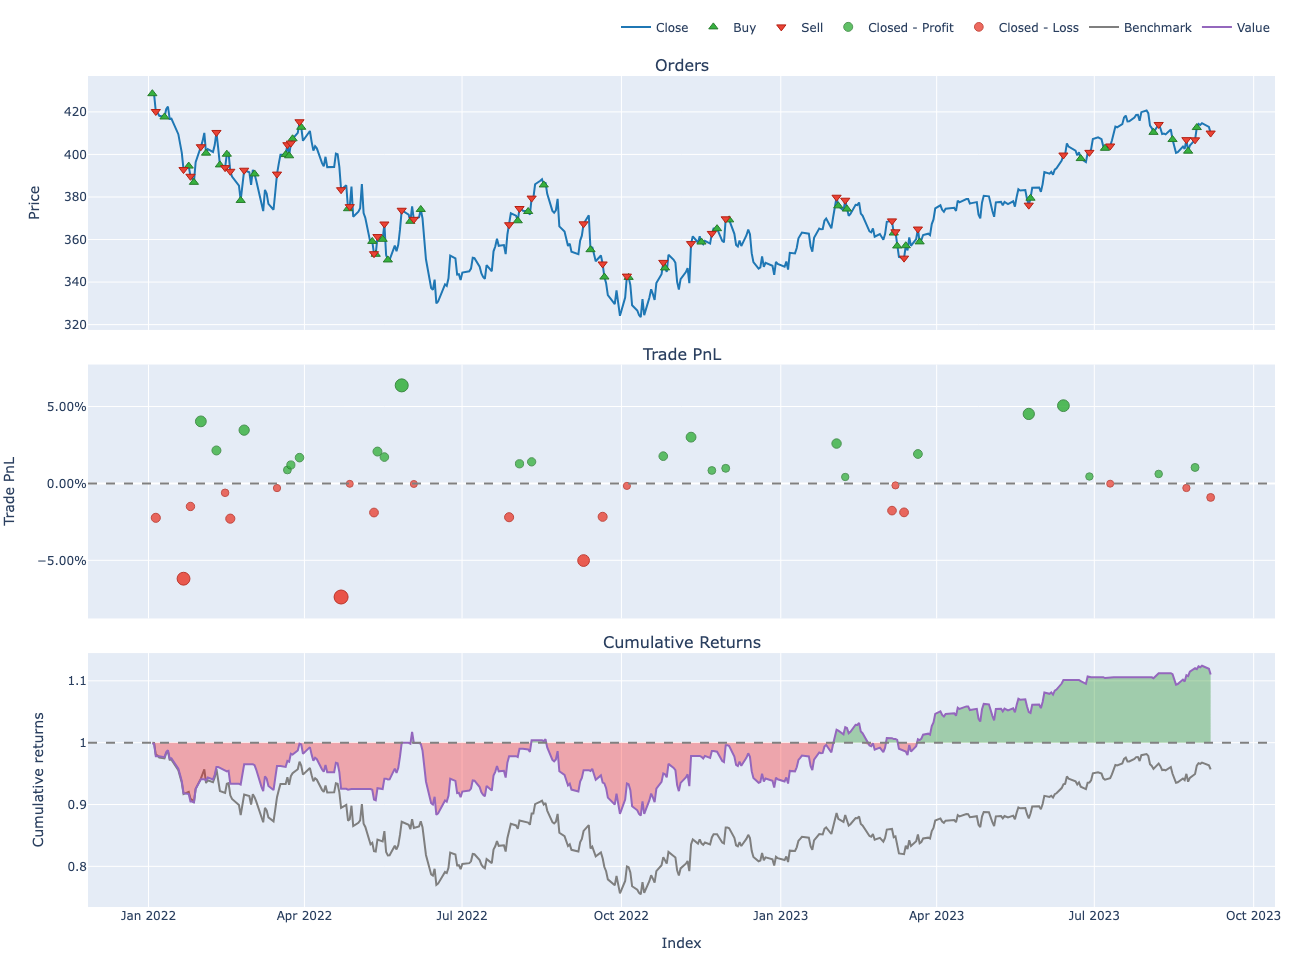

In [213]:
model_pf.plot().show()

In [214]:
stock_df_last_date[predictors]

,Open,High,Low,Close,Volume,Capital Gains,ratio_5,trend_5,ratio_15,trend_15,...,trend_60,ratio_90,trend_90,ratio_150,trend_150,rsi_14,rsi_30,rsi_60,rsi_90,rsi_150
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-07 04:00:00+00:00,407.170013,409.429993,406.859985,408.829987,2245800,0.0,0.992152,1.0,1.002849,8.0,...,33.0,1.022292,49.0,1.05493,81.0,61.922939,43.373318,54.423017,56.965712,54.641577


In [215]:
#Predict 9/8 stock trend on 9/7
tmr = model.predict(stock_df_last_date[predictors])
print(tmr)

[1]
